# FastSMC minimal working example notebook

This notebook demonstrates a minimal working example of the FastSMC python bindings.

Please make sure you have installed the python bindings by following the instructions in `../README.md` before attempting to run this notebook.

The example dataset was simulated using the setup described in the paper, corresponding to SNP data for 150 diploid individuals and a chromosomal region of 30 Mb, with recombination rate from chromosome 2 and under a European demographic model (see https://www.biorxiv.org/content/10.1101/2020.04.20.029819v1 for more details).

1. import the necessary modules, including from `asmc` which is installed with the Python bindings

In [1]:
%config InlineBackend.figure_formats = ['svg']

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from asmc import *

2. Find the example data provided with ASMC that we will use for this notebook

In [2]:
# Get the ASMC directory and check we're in the expected place
base_dir = os.path.abspath('..')
assert 'FILES' in os.listdir(base_dir)
assert 'README.md' in os.listdir(base_dir)

file_dir = os.path.join(base_dir, 'FILES', 'FASTSMC_EXAMPLE')
name_prefix = 'out.25.n300.chr2.len30.dens1.disc10-20-2000.demoCEU.mapnorm.array'
decoding_quantities_file = os.path.join(file_dir, f'{name_prefix}.decodingQuantities.gz')
assert os.path.isfile(decoding_quantities_file)

# Ouput files will be generated alongside this notebook in a directory named 'tmp_output'
output_dir = os.path.join(base_dir, 'notebooks', 'tmp_output')
os.makedirs(output_dir, exist_ok=True)
assert(os.path.isdir(output_dir))

3. Set the required parameters. At minimum we need to specify the input and output file roots, the location of the decoding quantities file, and that we want GERMLINE and FastSMC mode. When using the Python bindings, you should always validate the chosen parameters to ensure you have not selected anything incompatible.

In [3]:
params = DecodingParams()
params.decodingQuantFile = decoding_quantities_file
params.inFileRoot = os.path.join(file_dir, name_prefix)
params.outFileRoot = os.path.join(output_dir, 'fastsmc_output')
params.GERMLINE = True
params.FastSMC = True

assert params.validateParamsFastSMC()

4. Create the Python ASMC objects and run it. This should only take a few seconds.

In [4]:
decoding_quantities = DecodingQuantities(params.decodingQuantFile)
data = Data(params, decoding_quantities)
hmm = HMM(data, decoding_quantities, params)

fast_smc = FastSMC()
fast_smc.run(params, data, hmm)

5. Concatenate data

In [5]:
for job_ind in range(params.jobs):
    assert os.path.isfile(f'{params.outFileRoot}.{1 + job_ind}.{params.jobs}.FastSMC.ibd.gz')

frames = [pd.read_csv(f'{params.outFileRoot}.{x}.{params.jobs}.FastSMC.ibd.gz', sep='\t', header=None)
          for x in range(1, params.jobs + 1)]

all_data = pd.concat(frames)

col_names = ['ind1_famid', 'ind1_id', 'ind1_hap', 'ind2_famid', 'ind2_id', 'ind2_hap',
             'chromosome', 'ibd_start', 'ibd_end', 'ibd_score']

all_data.columns = col_names

# Calculate IBD segment length in number of base pairs
all_data.insert(9, 'ibd_length', all_data['ibd_end'] - all_data['ibd_start'])
all_data

,ind1_famid,ind1_id,ind1_hap,ind2_famid,ind2_id,ind2_hap,chromosome,ibd_start,ibd_end,ibd_length,ibd_score
0,1_124,1_124,2,1_142,1_142,1,1,8740,1020587,1011847,0.409944
1,1_124,1_124,2,1_142,1_142,1,1,1043477,1053631,10154,0.053834
2,1_124,1_124,2,1_142,1_142,1,1,2523383,2581995,58612,0.002812
3,1_88,1_88,2,1_132,1_132,2,1,8740,334181,325441,0.008598
4,1_88,1_88,2,1_132,1_132,2,1,389104,417542,28438,0.009023
...,...,...,...,...,...,...,...,...,...,...,...
5087,1_28,1_28,1,1_131,1_131,1,1,21527883,29849472,8321589,0.994679
5088,1_43,1_43,1,1_129,1_129,2,1,12663909,13048585,384676,0.005396
5089,1_43,1_43,1,1_129,1_129,2,1,20029494,20045610,16116,0.051746
5090,1_43,1_43,1,1_129,1_129,2,1,20052325,29849472,9797147,0.996158


6. Visualise data: here we simply bin the IBD segment length

<AxesSubplot:xlabel='IBD segments length (in kbp)'>

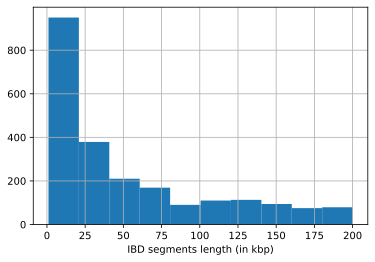

In [6]:
plt.xlabel("IBD segments length (in kbp)")
(all_data['ibd_length'] / 1000).hist(range=[1, 200])